In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import product

np.random.seed(3)
torch.manual_seed(3)
torch.cuda.manual_seed(3)
torch.cuda.manual_seed_all(3)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

pairs = [('GS','AVGO'), ('GS','JPM'), ('GS','XOM'), ('MSFT','AVGO'), ('MSFT','JPM'), ('MSFT','XOM'), ('CAT','AVGO'), ('CAT','JPM'), ('CAT','XOM')] # closing

downloadable_tickers = [ticker for pair in pairs for ticker in pair]

training_data = yf.download(downloadable_tickers, start = '2015-01-01', end = '2020-01-01')['Close']
testing_data = yf.download(downloadable_tickers, start = '2020-01-02', end = '2024-12-31')['Close']

/var/folders/qd/xclxh05s0x9509nblm6z434w0000gp/T/ipykernel_37829/1713782161.py:25: FutureWarning: YF.download() has changed argument auto_adjust default to True
  training_data = yf.download(downloadable_tickers, start = '2015-01-01', end = '2020-01-01')['Close']
[*********************100%***********************]  6 of 6 completed
/var/folders/qd/xclxh05s0x9509nblm6z434w0000gp/T/ipykernel_37829/1713782161.py:26: FutureWarning: YF.download() has changed argument auto_adjust default to True
  testing_data = yf.download(downloadable_tickers, start = '2020-01-02', end = '2024-12-31')['Close']
[*********************100%***********************]  6 of 6 completed


In [2]:
# def predict_mean_reversion_label(spread, window, threshold):
#     labels = []
#     mean = spread.mean()

#     for i in range(len(spread)):
#         future_spread = spread[i + 1 : i + 1 + window]
#         if len(future_spread) < window:
#             labels.append(np.nan)
#         elif any(abs(j - mean) < threshold for j in future_spread):
#             labels.append(1)
#         else:
#             labels.append(0)

#     return pd.Series(labels, index = spread.index)

def predict_mean_reversion_label(spread, lower, upper):
    mean = spread.mean()
    std = spread.std()
    z_scores = (spread - mean) / std

    labels = ((z_scores <= lower) | (z_scores >= upper)).astype(int)

    return pd.Series(labels, index=spread.index)

In [3]:
def zscore_calc_test(series, mean, std):
    return (series - mean) / std

def zscore_calc_train(series):
    return (series - series.mean()) / series.std(), series.mean(), series.std()

def create_features(spread, pair, window):
    df = pd.DataFrame({'spread': spread})

    df['z-score'] = (df['spread'] - df['spread'].mean()) / df['spread'].std()
    df['z-score_lag1'] = df['z-score'].shift(1)
    df['spread_lag1'] = df['spread'].shift(1)
    df['rolling_mean'] = df['spread'].rolling(window).mean()
    df['volatility'] = df['spread'].pct_change().rolling(window).std()
    df['z-score_lag2'] = df['z-score'].shift(2)
    df['z-score_lag5'] = df['z-score'].shift(5)

    df = df.dropna()
    return df

training_spreads = {}
testing_spreads = {}

X_train_dict = {}
y_train_dict = {}
X_test_dict = {}
y_test_dict = {}

# optimal_window_threshold = {'SPYG_IVW': {'window': 10, 'threshold': 0.03},
#                             'VOO_IVV': {'window': 10, 'threshold': 0.03},
#                             'IVE_SPYV': {'window': 10, 'threshold': 0.03},
#                             'IWB_SPLG': {'window': 10, 'threshold': 0.03},
#                             'IWM_SPSM': {'window': 10, 'threshold': 0.03},
#                             'VTWO_SPSM': {'window': 10, 'threshold': 0.03},
#                             'VO_IWB': {'window': 10, 'threshold': 0.03},
#                             'SPY_IVV': {'window': 10, 'threshold': 0.03}
# }

for etf1, etf2 in pairs:

    pair_name = f'{etf1}_{etf2}'

    window = 5

    train_z1, mean_z1, std_z1 = zscore_calc_train(training_data[etf1])
    train_z2, mean_z2, std_z2 = zscore_calc_train(training_data[etf2])

    test_z1 = zscore_calc_test(testing_data[etf1], mean_z1, std_z1)
    test_z2 = zscore_calc_test(testing_data[etf2], mean_z2, std_z2)

    training_spread, testing_spread = train_z1 - train_z2, test_z1 - test_z2
    training_spreads[pair_name], testing_spreads[pair_name] = training_spread, testing_spread

    train_features = create_features(training_spread, pair_name, window = window)
    test_features = create_features(testing_spread, pair_name, window = window)

    train_labels = predict_mean_reversion_label(training_spread, lower = -1, upper = 1)

    train_features['label'] = train_labels.loc[train_features.index]
    train_features = train_features.dropna(subset=['label'])

    test_labels = predict_mean_reversion_label(testing_spread, lower = -1, upper = 1)
    test_features['label'] = test_labels.loc[test_features.index]
    test_features = test_features.dropna(subset=['label'])

    X_train_dict[pair_name] = train_features.drop(columns=['label'])
    y_train_dict[pair_name] = train_features['label']
    X_test_dict[pair_name] = test_features.drop(columns=['label'])
    y_test_dict[pair_name] = test_features['label']


training_spreads_df = pd.DataFrame(training_spreads)
testing_spreads_df = pd.DataFrame(testing_spreads)

In [4]:
def create_sequences(X, y, window_size):
    X_seq, y_seq  = [], []

    for i in range(len(X) - window_size):
        X_seq.append(X.iloc[i : i + window_size].values)
        y_seq.append(y.iloc[i + window_size])

    return np.array(X_seq), np.array(y_seq)

In [5]:
class ClassificationLSTM(nn.Module):
    def __init__(self, hidden_size, num_layers, input_size, dropout = 0.0):
        super(ClassificationLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first = True)
        self.linear = nn.Linear(hidden_size, 1)
        dropout = dropout if num_layers > 1 else 0.0
        # self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]
        out = self.linear(out)
        # out = self.sigmoid(out)
        return out.squeeze()

In [6]:
def train_model(model, train_loader, criterion, optimizer, epochs = 50, device = 'cpu'):
    model.train()
    
    for epoch in range(epochs):
        total_loss = 0
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            preds = model(xb)
            loss = criterion(preds, yb.view(-1))
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1}/{epochs} - Loss: {total_loss / len(train_loader):.4f}")

In [7]:
def evaluate_model(model, pair_name, test_loader, device = 'cpu'):
    model.eval()
    all_preds = []
    all_true = []
    
    # optimal_thresholds = {'IEMG_EEM': 0.90,
    #                       'ARKK_ARKW': 0.50,
    #                       'TLT_SPTL': 0.50,
    #                       'SHY_VGSH': 0.80,
    #                       'SOXX_ITA': 0.30
    #                       }
    
    # threshold = optimal_thresholds[pair_name]

    with torch.no_grad():
        for xb, yb in test_loader:
            xb, yb = xb.to(device), yb.to(device)
            logits = model(xb)
            preds = torch.sigmoid(logits)
            all_preds.append(preds.cpu())
            all_true.append(yb.cpu())
    y_pred = torch.cat(all_preds).numpy()
    y_true = torch.cat(all_true).numpy()
    y_pred_label = (y_pred > 0.5).astype(int)
    accuracy = accuracy_score(y_true, y_pred_label)
    print("Test Accuracy:", accuracy)
    return y_true, y_pred, y_pred_label

In [8]:
def plot_labels(X_df, y_pred_label, pair_name):
    spread = X_df['spread']
    
    aligned_spread = spread[-len(y_pred_label):]
    predicted_points = aligned_spread[y_pred_label == 1]

    plt.figure(figsize=(12, 5))
    sns.lineplot(x=aligned_spread.index, y=aligned_spread.values, label='Spread', color='black')
    sns.scatterplot(x=predicted_points.index, y=predicted_points.values, color='green', label='Predicted Reversion', s=100, marker='o')
    plt.title(f"Predicted Mean Reversions of {pair_name}")
    plt.xlabel("Date")
    plt.ylabel("Spread")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [9]:
def print_confusion_matrix(y_true, y_pred_label):
    cm = confusion_matrix(y_true, y_pred_label, labels = [0, 1])
    print("Confusion Matrix:")
    print(cm)

In [10]:
def print_f1(y_true, y_pred_label):
    f1 = f1_score(y_true, y_pred_label)
    print(f"F1 Score: {f1:.4f}")

In [11]:
def run_pair(pair_name, X_train_dict, y_train_dict, X_test_dict, y_test_dict, epochs, device='cpu'):
    
    # params = {'IEMG_EEM': {'hidden_size': 30, 'lr': 0.001, 'num_layers': 1, 'window_size': 3, 'batch_size': 32, 'dropout': 0.0},
    #           'ARKK_ARKW': {'hidden_size': 70, 'lr': 0.0001, 'num_layers': 2, 'window_size': 5, 'batch_size': 128, 'dropout': 0.0},
    #           'TLT_SPTL': {'hidden_size': 70, 'lr': 0.0005, 'num_layers': 2, 'window_size': 5, 'batch_size': 32, 'dropout': 0.0},
    #           'SHY_VGSH': {'hidden_size': 30, 'lr': 0.001, 'num_layers': 2, 'window_size': 5, 'batch_size': 32, 'dropout': 0.2},
    #           'SOXX_ITA': {'hidden_size': 70, 'lr': 0.0005, 'num_layers': 1, 'window_size': 5, 'batch_size': 32, 'dropout': 0.0}
    #           }
    
    # hidden_size = params[pair_name]['hidden_size']
    # lr = params[pair_name]['lr']
    # num_layers = params[pair_name]['num_layers']
    # window_size = params[pair_name]['window_size']
    # batch_size = params[pair_name]['batch_size']
    # dropout = params[pair_name]['dropout']

    hidden_size = 70
    lr = 0.001
    num_layers = 2
    window_size = 5
    batch_size = 32
    dropout = 0.0

    X_df = X_train_dict[pair_name]
    y_series = y_train_dict[pair_name]

    X_seq, y_seq = create_sequences(X_df, y_series, window_size = window_size)

    X_train = torch.tensor(X_seq, dtype=torch.float32)
    y_train = torch.tensor(y_seq, dtype=torch.float32).unsqueeze(-1)

    pos_weight = torch.tensor([(len(y_train) - y_train.sum()) / y_train.sum()]).to(device)
    criterion = nn.BCEWithLogitsLoss(pos_weight = pos_weight)

    X_test_df = X_test_dict[pair_name]
    y_test_series = y_test_dict[pair_name]

    X_test_seq, y_test_seq = create_sequences(X_test_df, y_test_series, window_size = window_size)
    
    X_test = torch.tensor(X_test_seq, dtype=torch.float32)
    y_test = torch.tensor(y_test_seq, dtype=torch.float32).unsqueeze(-1)
    
    train_dataset = TensorDataset(X_train, y_train)
    test_dataset = TensorDataset(X_test, y_test)
    train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = False)
    test_loader = DataLoader(test_dataset, batch_size = batch_size, shuffle = False)
    
    model = ClassificationLSTM(input_size = 8, hidden_size = hidden_size, num_layers = num_layers, dropout = dropout).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr = lr)
    
    print(f"\nTraining model for pair: {pair_name}")
    train_model(model, train_loader, criterion, optimizer, epochs = epochs, device = device)
    
    print(f"\nEvaluating model for pair: {pair_name}")
    y_true, y_pred, y_pred_label = evaluate_model(model, pair_name, test_loader, device = device)

    plot_labels(X_test_df, y_pred_label, pair_name)

    print_confusion_matrix(y_true, y_pred_label)

    print_f1(y_true, y_pred_label)
    
    return model, y_true, y_pred

In [12]:
# grid search

def grid_search(pair_name, params, device = 'cpu'):
    window_size = params['window_size']
    epochs = params['epochs']
    hidden_size = params['hidden_size']
    lr = params['learning_rate']
    num_layers = params['num_layers']
    batch_size = params['batch_size']
    dropout = params['dropout']

    X_df = X_train_dict[pair_name]
    y_series = y_train_dict[pair_name]

    X_seq, y_seq = create_sequences(X_df, y_series, window_size = window_size)

    X_train = torch.tensor(X_seq, dtype=torch.float32)
    y_train = torch.tensor(y_seq, dtype=torch.float32).unsqueeze(-1)

    pos_weight = torch.tensor([(len(y_train) - y_train.sum()) / y_train.sum()]).to(device)
    criterion = nn.BCEWithLogitsLoss(pos_weight = pos_weight)

    X_test_df = X_test_dict[pair_name]
    y_test_series = y_test_dict[pair_name]

    X_test_seq, y_test_seq = create_sequences(X_test_df, y_test_series, window_size = window_size)

    X_test = torch.tensor(X_test_seq, dtype=torch.float32)
    y_test = torch.tensor(y_test_seq, dtype=torch.float32).unsqueeze(-1)

    train_dataset = TensorDataset(X_train, y_train)
    test_dataset = TensorDataset(X_test, y_test)
    train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size = batch_size, shuffle=False)

    model = ClassificationLSTM(input_size = 8, hidden_size = hidden_size, num_layers = num_layers, dropout = dropout).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr = lr)

    train_model(model, train_loader, criterion, optimizer, epochs = epochs, device = device)

    y_true, y_pred, y_pred_label = evaluate_model(model, pair_name, test_loader, device = device)

    f1 = f1_score(y_true, y_pred_label)

    return f1, model, params

In [13]:
def grid_search_for_pair(pair_name, param_grid, device='cpu'):
    keys, values = zip(*param_grid.items())
    best_f1 = -np.inf
    best_params = None
    best_model = None

    for v in product(*values):
        params = dict(zip(keys, v))
        print(f"Testing params: {params}")
        f1, model, _ = grid_search(pair_name, params, device=device)
        print(f"F1 Score: {f1:.4f}")
        if f1 > best_f1:
            best_f1 = f1
            best_params = params
            best_model = model

    print(f"Best params for {pair_name}: {best_params}")
    print(f"Best F1 score: {best_f1:.4f}")
    return best_model, best_params, best_f1


Training model for pair: GS_AVGO
Epoch 1/50 - Loss: 0.8503
Epoch 2/50 - Loss: 0.7953
Epoch 3/50 - Loss: 0.7133
Epoch 4/50 - Loss: 0.5418
Epoch 5/50 - Loss: 0.6402
Epoch 6/50 - Loss: 0.4689
Epoch 7/50 - Loss: 0.3936
Epoch 8/50 - Loss: 0.3998
Epoch 9/50 - Loss: 0.3259
Epoch 10/50 - Loss: 0.3293
Epoch 11/50 - Loss: 0.3245
Epoch 12/50 - Loss: 0.3083
Epoch 13/50 - Loss: 0.2992
Epoch 14/50 - Loss: 0.2959
Epoch 15/50 - Loss: 0.2932
Epoch 16/50 - Loss: 0.2902
Epoch 17/50 - Loss: 0.2873
Epoch 18/50 - Loss: 0.2848
Epoch 19/50 - Loss: 0.2826
Epoch 20/50 - Loss: 0.2806
Epoch 21/50 - Loss: 0.2785
Epoch 22/50 - Loss: 0.2766
Epoch 23/50 - Loss: 0.2746
Epoch 24/50 - Loss: 0.2728
Epoch 25/50 - Loss: 0.2709
Epoch 26/50 - Loss: 0.2690
Epoch 27/50 - Loss: 0.2672
Epoch 28/50 - Loss: 0.2653
Epoch 29/50 - Loss: 0.2633
Epoch 30/50 - Loss: 0.2614
Epoch 31/50 - Loss: 0.2594
Epoch 32/50 - Loss: 0.2573
Epoch 33/50 - Loss: 0.2553
Epoch 34/50 - Loss: 0.2532
Epoch 35/50 - Loss: 0.2511
Epoch 36/50 - Loss: 0.2490
Epo

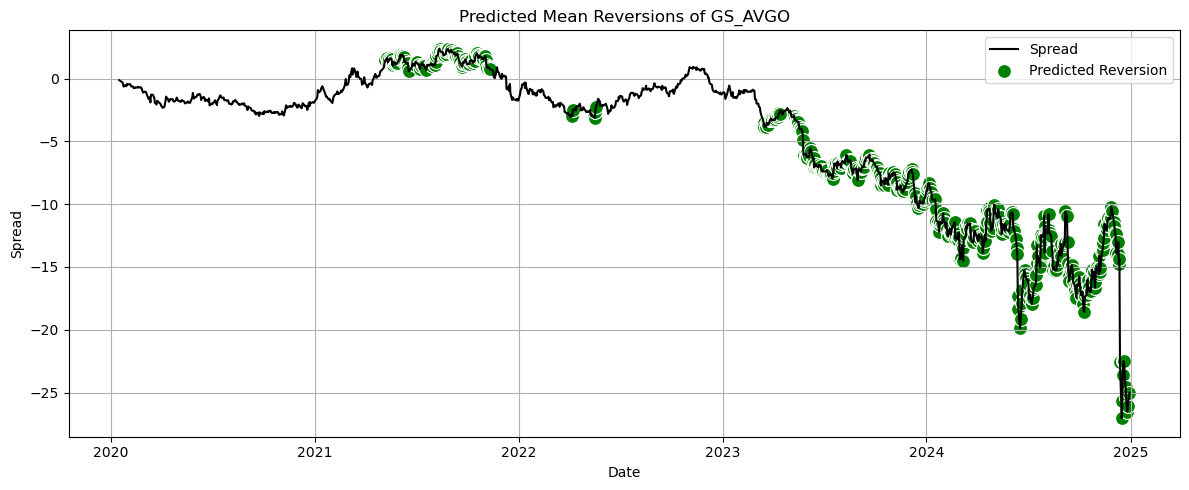

Confusion Matrix:
[[683 227]
 [  3 334]]
F1 Score: 0.7439

Training model for pair: GS_JPM
Epoch 1/50 - Loss: 0.9028
Epoch 2/50 - Loss: 0.8315
Epoch 3/50 - Loss: 0.7594
Epoch 4/50 - Loss: 0.7277
Epoch 5/50 - Loss: 0.5382
Epoch 6/50 - Loss: 0.4079
Epoch 7/50 - Loss: 0.3512
Epoch 8/50 - Loss: 0.3190
Epoch 9/50 - Loss: 0.3147
Epoch 10/50 - Loss: 0.3105
Epoch 11/50 - Loss: 0.3066
Epoch 12/50 - Loss: 0.3031
Epoch 13/50 - Loss: 0.3000
Epoch 14/50 - Loss: 0.2975
Epoch 15/50 - Loss: 0.2964
Epoch 16/50 - Loss: 0.2999
Epoch 17/50 - Loss: 0.3214
Epoch 18/50 - Loss: 0.3605
Epoch 19/50 - Loss: 0.2991
Epoch 20/50 - Loss: 0.2783
Epoch 21/50 - Loss: 0.2773
Epoch 22/50 - Loss: 0.2779
Epoch 23/50 - Loss: 0.2798
Epoch 24/50 - Loss: 0.2835
Epoch 25/50 - Loss: 0.2865
Epoch 26/50 - Loss: 0.2836
Epoch 27/50 - Loss: 0.2746
Epoch 28/50 - Loss: 0.2667
Epoch 29/50 - Loss: 0.2630
Epoch 30/50 - Loss: 0.2631
Epoch 31/50 - Loss: 0.2655
Epoch 32/50 - Loss: 0.2657
Epoch 33/50 - Loss: 0.2590
Epoch 34/50 - Loss: 0.2504


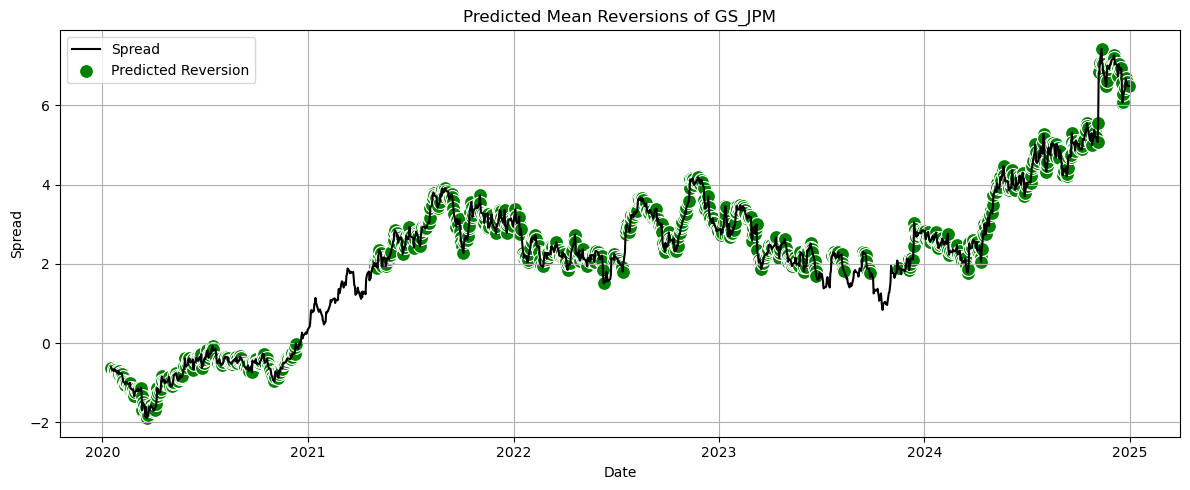

Confusion Matrix:
[[179 664]
 [ 16 388]]
F1 Score: 0.5330

Training model for pair: GS_XOM
Epoch 1/50 - Loss: 0.9489
Epoch 2/50 - Loss: 0.8336
Epoch 3/50 - Loss: 0.6347
Epoch 4/50 - Loss: 0.5416
Epoch 5/50 - Loss: 0.4895
Epoch 6/50 - Loss: 0.4394
Epoch 7/50 - Loss: 0.4290
Epoch 8/50 - Loss: 0.4183
Epoch 9/50 - Loss: 0.4049
Epoch 10/50 - Loss: 0.3938
Epoch 11/50 - Loss: 0.3841
Epoch 12/50 - Loss: 0.3754
Epoch 13/50 - Loss: 0.3679
Epoch 14/50 - Loss: 0.3604
Epoch 15/50 - Loss: 0.3530
Epoch 16/50 - Loss: 0.3466
Epoch 17/50 - Loss: 0.3408
Epoch 18/50 - Loss: 0.3353
Epoch 19/50 - Loss: 0.3297
Epoch 20/50 - Loss: 0.3240
Epoch 21/50 - Loss: 0.3180
Epoch 22/50 - Loss: 0.3115
Epoch 23/50 - Loss: 0.3043
Epoch 24/50 - Loss: 0.2967
Epoch 25/50 - Loss: 0.2894
Epoch 26/50 - Loss: 0.2830
Epoch 27/50 - Loss: 0.2774
Epoch 28/50 - Loss: 0.2718
Epoch 29/50 - Loss: 0.2658
Epoch 30/50 - Loss: 0.2600
Epoch 31/50 - Loss: 0.2542
Epoch 32/50 - Loss: 0.2487
Epoch 33/50 - Loss: 0.2435
Epoch 34/50 - Loss: 0.2388


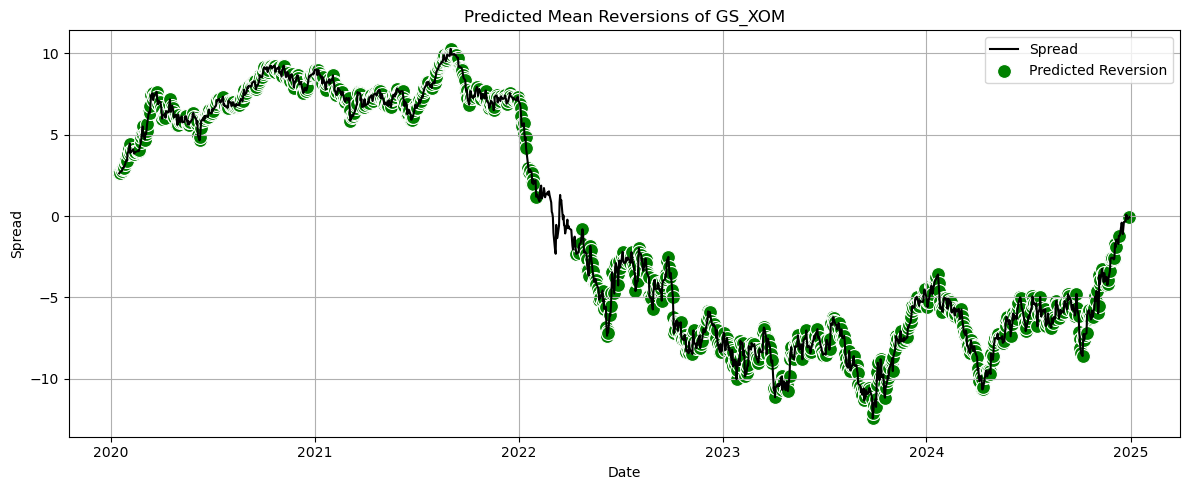

Confusion Matrix:
[[ 69 520]
 [  0 658]]
F1 Score: 0.7168

Training model for pair: MSFT_AVGO
Epoch 1/50 - Loss: 0.9096
Epoch 2/50 - Loss: 0.8309
Epoch 3/50 - Loss: 0.6543
Epoch 4/50 - Loss: 0.6637
Epoch 5/50 - Loss: 0.5135
Epoch 6/50 - Loss: 0.4651
Epoch 7/50 - Loss: 0.4384
Epoch 8/50 - Loss: 0.4186
Epoch 9/50 - Loss: 0.3980
Epoch 10/50 - Loss: 0.3834
Epoch 11/50 - Loss: 0.3738
Epoch 12/50 - Loss: 0.3650
Epoch 13/50 - Loss: 0.3553
Epoch 14/50 - Loss: 0.3462
Epoch 15/50 - Loss: 0.3377
Epoch 16/50 - Loss: 0.3298
Epoch 17/50 - Loss: 0.3222
Epoch 18/50 - Loss: 0.3146
Epoch 19/50 - Loss: 0.3067
Epoch 20/50 - Loss: 0.2984
Epoch 21/50 - Loss: 0.2895
Epoch 22/50 - Loss: 0.2810
Epoch 23/50 - Loss: 0.2756
Epoch 24/50 - Loss: 0.2679
Epoch 25/50 - Loss: 0.2729
Epoch 26/50 - Loss: 0.2585
Epoch 27/50 - Loss: 0.2616
Epoch 28/50 - Loss: 0.2473
Epoch 29/50 - Loss: 0.2481
Epoch 30/50 - Loss: 0.2402
Epoch 31/50 - Loss: 0.2496
Epoch 32/50 - Loss: 0.2334
Epoch 33/50 - Loss: 0.2401
Epoch 34/50 - Loss: 0.22

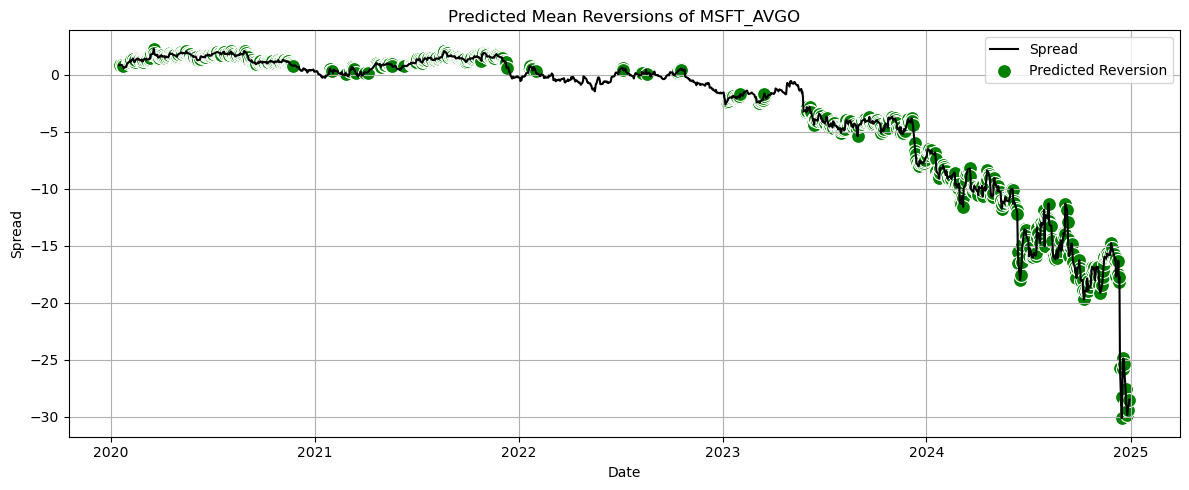

Confusion Matrix:
[[438 595]
 [  0 214]]
F1 Score: 0.4184

Training model for pair: MSFT_JPM
Epoch 1/50 - Loss: 0.9196
Epoch 2/50 - Loss: 0.8491
Epoch 3/50 - Loss: 0.6389
Epoch 4/50 - Loss: 0.6188
Epoch 5/50 - Loss: 0.4322
Epoch 6/50 - Loss: 0.3375
Epoch 7/50 - Loss: 0.3141
Epoch 8/50 - Loss: 0.3123
Epoch 9/50 - Loss: 0.3018
Epoch 10/50 - Loss: 0.3003
Epoch 11/50 - Loss: 0.2919
Epoch 12/50 - Loss: 0.2894
Epoch 13/50 - Loss: 0.2831
Epoch 14/50 - Loss: 0.2794
Epoch 15/50 - Loss: 0.2745
Epoch 16/50 - Loss: 0.2703
Epoch 17/50 - Loss: 0.2667
Epoch 18/50 - Loss: 0.2642
Epoch 19/50 - Loss: 0.2627
Epoch 20/50 - Loss: 0.2598
Epoch 21/50 - Loss: 0.2544
Epoch 22/50 - Loss: 0.2494
Epoch 23/50 - Loss: 0.2461
Epoch 24/50 - Loss: 0.2419
Epoch 25/50 - Loss: 0.2353
Epoch 26/50 - Loss: 0.2312
Epoch 27/50 - Loss: 0.2306
Epoch 28/50 - Loss: 0.2276
Epoch 29/50 - Loss: 0.2199
Epoch 30/50 - Loss: 0.2143
Epoch 31/50 - Loss: 0.2128
Epoch 32/50 - Loss: 0.2109
Epoch 33/50 - Loss: 0.2065
Epoch 34/50 - Loss: 0.204

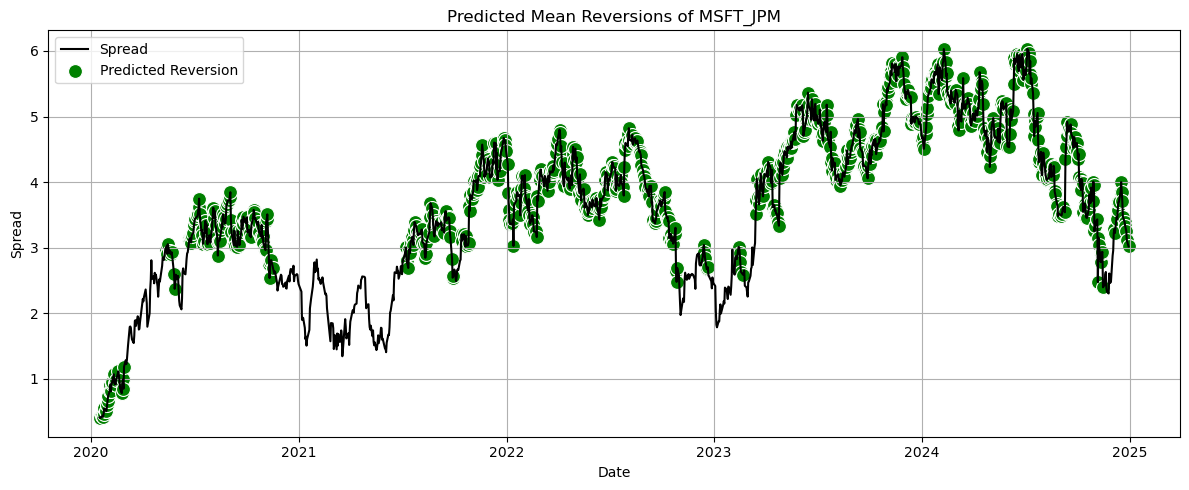

Confusion Matrix:
[[183 676]
 [150 238]]
F1 Score: 0.3656

Training model for pair: MSFT_XOM
Epoch 1/50 - Loss: 0.9630
Epoch 2/50 - Loss: 0.8282
Epoch 3/50 - Loss: 0.5412
Epoch 4/50 - Loss: 0.3929
Epoch 5/50 - Loss: 0.3915
Epoch 6/50 - Loss: 0.3830
Epoch 7/50 - Loss: 0.3644
Epoch 8/50 - Loss: 0.3569
Epoch 9/50 - Loss: 0.3509
Epoch 10/50 - Loss: 0.3453
Epoch 11/50 - Loss: 0.3406
Epoch 12/50 - Loss: 0.3366
Epoch 13/50 - Loss: 0.3331
Epoch 14/50 - Loss: 0.3296
Epoch 15/50 - Loss: 0.3256
Epoch 16/50 - Loss: 0.3209
Epoch 17/50 - Loss: 0.3158
Epoch 18/50 - Loss: 0.3102
Epoch 19/50 - Loss: 0.3046
Epoch 20/50 - Loss: 0.2987
Epoch 21/50 - Loss: 0.2969
Epoch 22/50 - Loss: 0.2928
Epoch 23/50 - Loss: 0.3141
Epoch 24/50 - Loss: 0.2879
Epoch 25/50 - Loss: 0.2786
Epoch 26/50 - Loss: 0.2769
Epoch 27/50 - Loss: 0.2754
Epoch 28/50 - Loss: 0.2819
Epoch 29/50 - Loss: 0.2641
Epoch 30/50 - Loss: 0.2606
Epoch 31/50 - Loss: 0.2613
Epoch 32/50 - Loss: 0.2660
Epoch 33/50 - Loss: 0.2514
Epoch 34/50 - Loss: 0.249

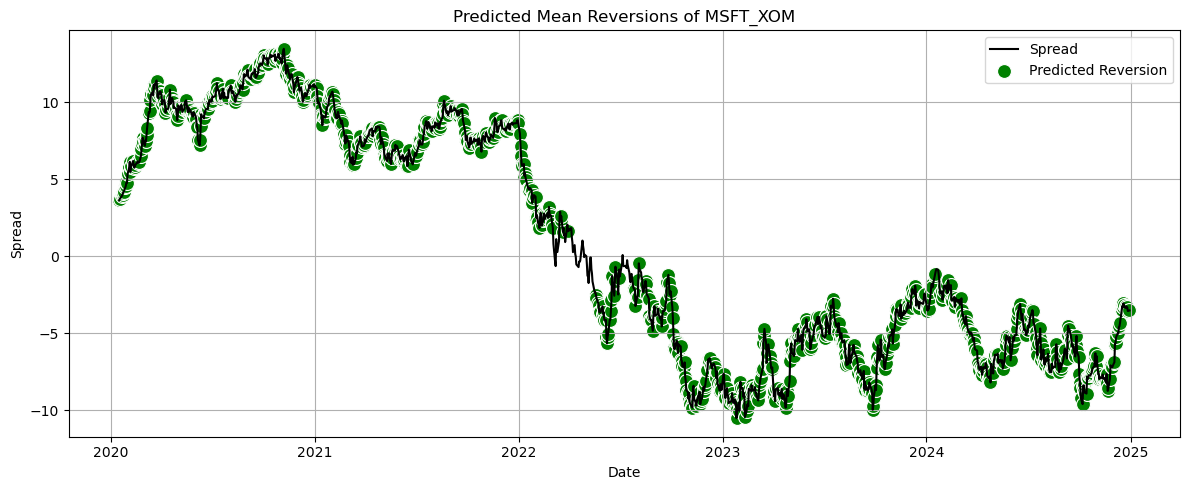

Confusion Matrix:
[[ 81 578]
 [  0 588]]
F1 Score: 0.6705

Training model for pair: CAT_AVGO
Epoch 1/50 - Loss: 0.9116
Epoch 2/50 - Loss: 0.7902
Epoch 3/50 - Loss: 0.6670
Epoch 4/50 - Loss: 0.5638
Epoch 5/50 - Loss: 0.4538
Epoch 6/50 - Loss: 0.3878
Epoch 7/50 - Loss: 0.3689
Epoch 8/50 - Loss: 0.3530
Epoch 9/50 - Loss: 0.3368
Epoch 10/50 - Loss: 0.3251
Epoch 11/50 - Loss: 0.3169
Epoch 12/50 - Loss: 0.3100
Epoch 13/50 - Loss: 0.3044
Epoch 14/50 - Loss: 0.3003
Epoch 15/50 - Loss: 0.2977
Epoch 16/50 - Loss: 0.2943
Epoch 17/50 - Loss: 0.2874
Epoch 18/50 - Loss: 0.2783
Epoch 19/50 - Loss: 0.2707
Epoch 20/50 - Loss: 0.2663
Epoch 21/50 - Loss: 0.2631
Epoch 22/50 - Loss: 0.2582
Epoch 23/50 - Loss: 0.2519
Epoch 24/50 - Loss: 0.2469
Epoch 25/50 - Loss: 0.2433
Epoch 26/50 - Loss: 0.2385
Epoch 27/50 - Loss: 0.2326
Epoch 28/50 - Loss: 0.2280
Epoch 29/50 - Loss: 0.2256
Epoch 30/50 - Loss: 0.2241
Epoch 31/50 - Loss: 0.2168
Epoch 32/50 - Loss: 0.2074
Epoch 33/50 - Loss: 0.2041
Epoch 34/50 - Loss: 0.204

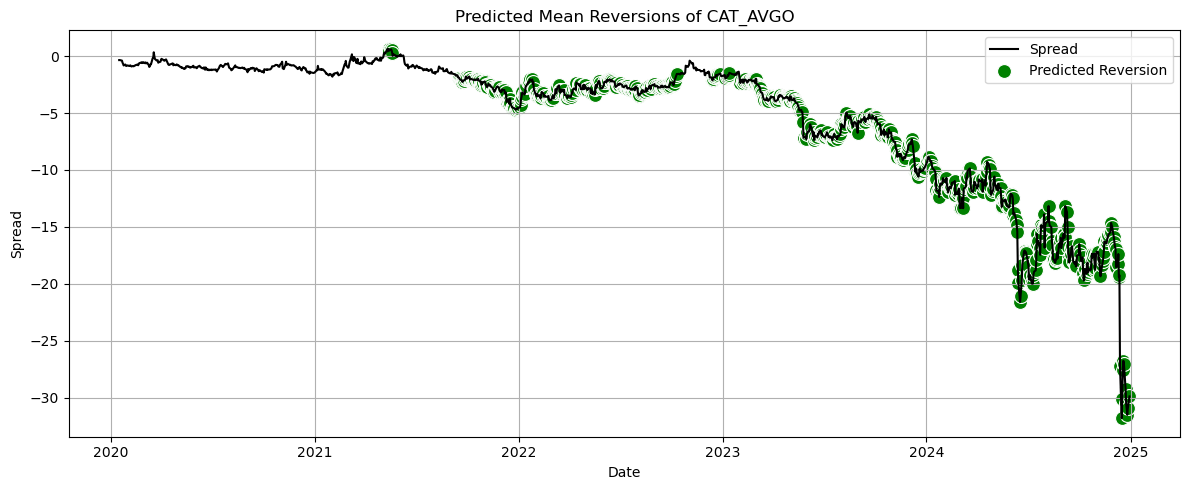

Confusion Matrix:
[[476 551]
 [  0 220]]
F1 Score: 0.4440

Training model for pair: CAT_JPM
Epoch 1/50 - Loss: 0.9781
Epoch 2/50 - Loss: 0.9095
Epoch 3/50 - Loss: 0.7575
Epoch 4/50 - Loss: 0.6027
Epoch 5/50 - Loss: 0.5376
Epoch 6/50 - Loss: 0.4993
Epoch 7/50 - Loss: 0.4553
Epoch 8/50 - Loss: 0.4411
Epoch 9/50 - Loss: 0.4239
Epoch 10/50 - Loss: 0.4122
Epoch 11/50 - Loss: 0.4003
Epoch 12/50 - Loss: 0.3927
Epoch 13/50 - Loss: 0.3841
Epoch 14/50 - Loss: 0.3764
Epoch 15/50 - Loss: 0.3693
Epoch 16/50 - Loss: 0.3631
Epoch 17/50 - Loss: 0.3571
Epoch 18/50 - Loss: 0.3512
Epoch 19/50 - Loss: 0.3456
Epoch 20/50 - Loss: 0.3401
Epoch 21/50 - Loss: 0.3347
Epoch 22/50 - Loss: 0.3291
Epoch 23/50 - Loss: 0.3234
Epoch 24/50 - Loss: 0.3176
Epoch 25/50 - Loss: 0.3124
Epoch 26/50 - Loss: 0.3077
Epoch 27/50 - Loss: 0.3035
Epoch 28/50 - Loss: 0.3006
Epoch 29/50 - Loss: 0.2991
Epoch 30/50 - Loss: 0.2985
Epoch 31/50 - Loss: 0.2947
Epoch 32/50 - Loss: 0.2876
Epoch 33/50 - Loss: 0.2802
Epoch 34/50 - Loss: 0.2737

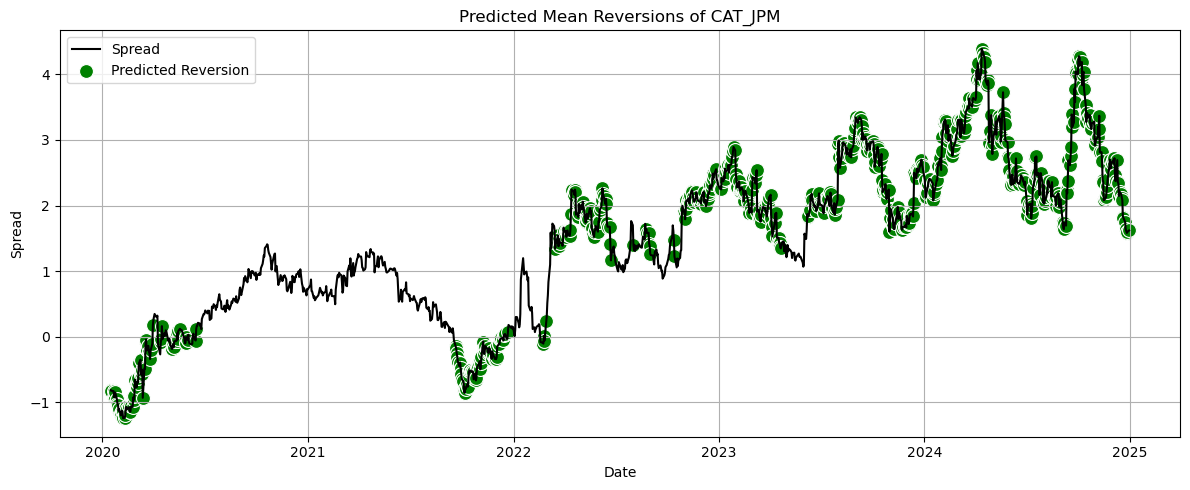

Confusion Matrix:
[[444 382]
 [ 75 346]]
F1 Score: 0.6023

Training model for pair: CAT_XOM
Epoch 1/50 - Loss: 0.9216
Epoch 2/50 - Loss: 0.7421
Epoch 3/50 - Loss: 0.4369
Epoch 4/50 - Loss: 0.4029
Epoch 5/50 - Loss: 0.3667
Epoch 6/50 - Loss: 0.3528
Epoch 7/50 - Loss: 0.3483
Epoch 8/50 - Loss: 0.3379
Epoch 9/50 - Loss: 0.3263
Epoch 10/50 - Loss: 0.3146
Epoch 11/50 - Loss: 0.3031
Epoch 12/50 - Loss: 0.2925
Epoch 13/50 - Loss: 0.2835
Epoch 14/50 - Loss: 0.2762
Epoch 15/50 - Loss: 0.2694
Epoch 16/50 - Loss: 0.2626
Epoch 17/50 - Loss: 0.2561
Epoch 18/50 - Loss: 0.2499
Epoch 19/50 - Loss: 0.2442
Epoch 20/50 - Loss: 0.2384
Epoch 21/50 - Loss: 0.2328
Epoch 22/50 - Loss: 0.2273
Epoch 23/50 - Loss: 0.2221
Epoch 24/50 - Loss: 0.2168
Epoch 25/50 - Loss: 0.2115
Epoch 26/50 - Loss: 0.2064
Epoch 27/50 - Loss: 0.2013
Epoch 28/50 - Loss: 0.1963
Epoch 29/50 - Loss: 0.1913
Epoch 30/50 - Loss: 0.1865
Epoch 31/50 - Loss: 0.1818
Epoch 32/50 - Loss: 0.1774
Epoch 33/50 - Loss: 0.1732
Epoch 34/50 - Loss: 0.1694

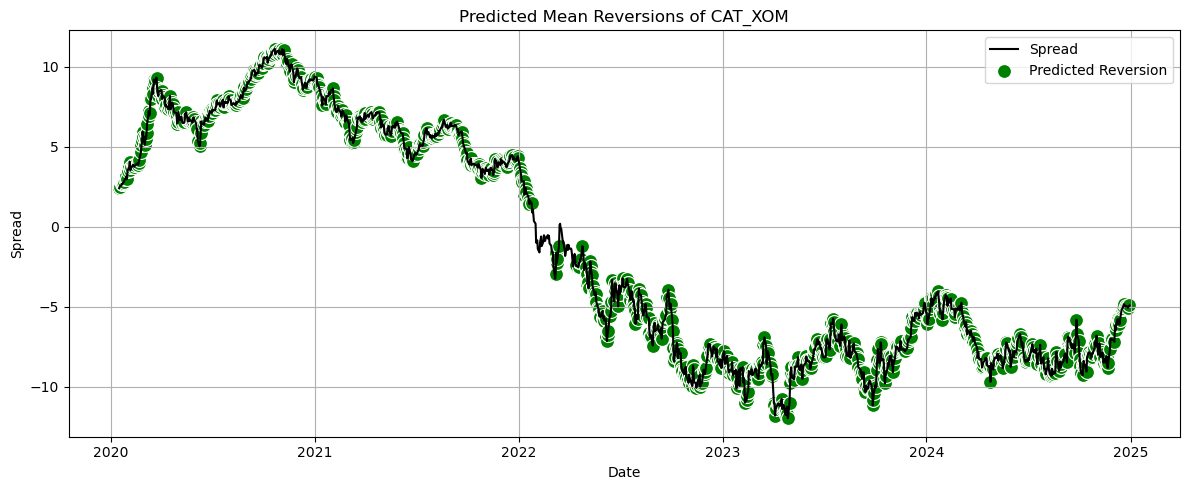

Confusion Matrix:
[[ 54 619]
 [  0 574]]
F1 Score: 0.6497
{'GS_AVGO': {'model': ClassificationLSTM(
  (lstm): LSTM(8, 70, num_layers=2, batch_first=True)
  (linear): Linear(in_features=70, out_features=1, bias=True)
), 'y_true': array([[0.],
       [0.],
       [0.],
       ...,
       [1.],
       [1.],
       [1.]], shape=(1247, 1), dtype=float32), 'y_pred': array([1.3984101e-04, 1.3406224e-04, 1.2776149e-04, ..., 9.9993467e-01,
       9.9993467e-01, 9.9993503e-01], shape=(1247,), dtype=float32)}, 'GS_JPM': {'model': ClassificationLSTM(
  (lstm): LSTM(8, 70, num_layers=2, batch_first=True)
  (linear): Linear(in_features=70, out_features=1, bias=True)
), 'y_true': array([[1.],
       [1.],
       [1.],
       ...,
       [1.],
       [1.],
       [1.]], shape=(1247, 1), dtype=float32), 'y_pred': array([0.99519616, 0.993834  , 0.99213225, ..., 0.9996302 , 0.99962795,
       0.99963033], shape=(1247,), dtype=float32)}, 'GS_XOM': {'model': ClassificationLSTM(
  (lstm): LSTM(8, 70, num_la

In [14]:
results = {}

# param_grid = {
#     'hidden_size': [30, 70],
#     'learning_rate': [0.001, 0.0005, 0.0001],
#     'window_size': [3, 5, 7],
#     'epochs': [50],
#     'num_layers': [1, 2],
#     'batch_size': [32, 64, 128],
#     'dropout': [0.0, 0.2]
# }

# best_params_all = {}
# best_f1_all = {}

# for pair_name in training_spreads_df.columns:
#     print(f"\nStarting grid search for {pair_name}")
#     model, params, f1 = grid_search_for_pair(pair_name, param_grid, device='cpu')
#     results[pair_name] = {'model': model}
#     best_params_all[pair_name] = params
#     best_f1_all[pair_name] = f1

for pair_name in training_spreads_df.columns:
    model, y_true, y_pred = run_pair(
        pair_name,
        X_train_dict,
        y_train_dict,
        X_test_dict,
        y_test_dict,
        epochs = 50,
        device = 'cpu'
    )
    results[pair_name] = {'model': model, 'y_true': y_true, 'y_pred': y_pred}

print(results)

In [15]:
def build_prices(pair_list, testing_data, X_test_dict):
    test_prices_dict = {}

    for pair in pair_list:
        etf1, etf2 = pair.split('_')

        data = yf.download(tickers = downloadable_tickers, start = '2020-01-02', end = '2024-12-31')[['Open', 'Close', 'High', 'Low']]
        new_data = (data['Open'] + data['High'] + data['Low'] + data['Close']) / 4

        price_df = new_data[[etf1, etf2]].copy()
        price_df.columns = ['price_long', 'price_short']

        test_index = X_test_dict[pair].index
        aligned_prices = price_df.loc[test_index]

        test_prices_dict[pair] = aligned_prices

    return test_prices_dict

In [16]:
def compute_max_drawdown(equity_curve):
    running_max = equity_curve.cummax()
    drawdowns = equity_curve / running_max - 1.0
    max_drawdown = drawdowns.min()
    
    return max_drawdown, drawdowns

In [17]:
def plot_combined_equity_and_drawdown(equity):
    peak = equity.cummax()
    drawdown = (equity - peak) / peak

    fig, ax = plt.subplots(2, 1, figsize=(12, 6), sharex=True)
    ax[0].plot(equity, label='Combined Equity')
    ax[0].set_title("Combined Equity Curve")
    ax[0].legend()
    ax[0].grid()

    ax[1].plot(drawdown, color='red', label='Drawdown')
    ax[1].set_title("Drawdown Over Time")
    ax[1].legend()
    ax[1].grid()

    plt.tight_layout()
    plt.show()


In [18]:
def simulate_portfolio(
    X_df, probs, y_pred_label, prices_df,
    initial_cash_per_pair = 100.0,
    holding_period = 10,
    entry_threshold = 1.0,
):
    df = X_df.copy()
    df = df.iloc[-len(y_pred_label):].copy()

    df['prob'] = probs
    df['label'] = y_pred_label
    df = df.join(prices_df)

    cash = initial_cash_per_pair
    equity = pd.Series(index = df.index, dtype = float)
    equity.iloc[0] = cash
    trades = []

    i = 0
    n = len(df)

    while i < n - holding_period:
        row = df.iloc[i]
        prob = row['prob']
        zscore = row['z-score']
        price_long_in = row['price_long']
        price_short_in = row['price_short']

        if (prob > 0.5 and abs(zscore) >= entry_threshold):
            entry_idx = i
            exit_idx = i + holding_period
            entry_date = df.index[entry_idx]
            exit_date = df.index[exit_idx]

            price_long_out = df.iloc[exit_idx]['price_long']
            price_short_out = df.iloc[exit_idx]['price_short']

            notional = cash
            long_dollars, short_dollars = notional / 2.0, notional / 2.0

            if zscore > 0:
                shares_short_long = short_dollars / price_long_in
                shares_long_short = long_dollars / price_short_in

                pnl = (shares_long_short * (price_short_out - price_short_in)) + \
                      (shares_short_long * (price_long_in - price_long_out))
                direction = "Short ETF1 / Long ETF2"
            else:
                shares_long_long = long_dollars / price_long_in
                shares_short_short = short_dollars / price_short_in

                pnl = (shares_long_long * (price_long_out - price_long_in)) + \
                      (shares_short_short * (price_short_in - price_short_out))
                direction = "Long ETF1 / Short ETF2"

            cash += pnl
            equity.loc[exit_date] = cash

            trades.append({
                "entry_date": entry_date,
                "exit_date": exit_date,
                "prob": prob,
                "direction": direction,
                "pnl": pnl,
                "notional": notional
            })

            i = exit_idx + 1
        else:
            equity.iloc[i] = cash
            i += 1

    equity.ffill(inplace = True)
    return equity, trades

In [19]:
def run_simulation(results, X_test_dict, testing_data):
    pair_list = list(X_test_dict.keys())
    test_prices_dict = build_prices(pair_list, testing_data, X_test_dict)

    total_cash = 0
    combined_equity = pd.Series(dtype=float)
    pair_trade_counts = {}
    pair_pnls = {}
    pair_sharpes = {}
    pair_drawdowns = {}
    pair_equities = {}

    plt.figure(figsize=(12, 6))

    for pair_name in pair_list:
        model_info = results[pair_name]
        model = model_info['model']
        y_true = model_info['y_true']
        y_pred = model_info['y_pred']

        probs = torch.sigmoid(torch.tensor(y_pred)).squeeze().numpy()
        y_pred_label = (probs > 0.5).astype(int)

        prices_df = test_prices_dict[pair_name]
        X_test_df = X_test_dict[pair_name]

        equity, trades = simulate_portfolio(X_test_df, probs, y_pred_label, prices_df)

        pair_equities[pair_name] = equity
        max_dd, _ = compute_max_drawdown(equity)
        pair_drawdowns[pair_name] = max_dd

        pair_returns = equity.pct_change().dropna()

        if pair_returns.std() != 0:
            sharpe = (pair_returns.mean() / pair_returns.std()) * np.sqrt(252)
        else:
            sharpe = np.nan

        pair_sharpes[pair_name] = sharpe

        total_cash += equity.iloc[-1]
        pair_trade_counts[pair_name] = len(trades)
        pair_pnls[pair_name] = [t['pnl'] for t in trades]

        if combined_equity.empty:
            equity.name = pair_name
            combined_equity = equity.to_frame()
        else:
            equity.name = pair_name
            combined_equity = pd.concat([combined_equity, equity], axis=1)

        sns.lineplot(x = equity.index, y = equity.values, label = pair_name)

    combined_equity = combined_equity.fillna(method='ffill').fillna(method='bfill')
    combined_equity['Total'] = combined_equity.sum(axis=1)


    plt.title("LSTM Equity Curve by Pair", fontsize=15, weight='bold')
    plt.xlabel("Date", fontsize=12)
    plt.ylabel("Portfolio Value ($)", fontsize=12)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    print(f"\nFinal Portfolio Value: ${total_cash:,.2f}")
    print("\nTrade Summary:")
    for pair, count in pair_trade_counts.items():
        total_pnl = sum(pair_pnls[pair])
        avg_pnl = np.mean(pair_pnls[pair]) if pair_pnls[pair] else 0
        print(f"  {pair}: {count} trades | Total PnL: ${total_pnl:.2f} | Avg PnL: ${avg_pnl:.2f}")

    yearly = combined_equity.resample('YE').last()
    print("\nYear-End Portfolio Values:")
    print(yearly)

    print("\nSharpe Ratios by Pair:")
    for pair, sharpe in pair_sharpes.items():
        print(f"{pair}: Sharpe Ratio = {sharpe:.2f}")

    combined_returns = combined_equity['Total'].pct_change().dropna()
    sharpe_ratio = (combined_returns.mean() / combined_returns.std()) * np.sqrt(252)
    print(f"\nTotal Sharpe Ratio: {sharpe_ratio:.2f}")

    print("\nMax Drawdowns by Pair:")
    for pair, drawdown in pair_drawdowns.items():
        print(f"{pair}: Max Drawdown = {drawdown:.2%}")

    max_dd, drawdowns = compute_max_drawdown(combined_equity['Total'])
    print(f"\nTotal Max Drawdown: {max_dd:.2%}")

    plot_combined_equity_and_drawdown(combined_equity['Total'])

    for pair in combined_equity.columns:
        print(f"Pair: {pair}")
        print(combined_equity[pair].tail(10))  # show last 10 rows for this pair
        print("-" * 40)

    cumulative_equity = combined_equity['Total']

/var/folders/qd/xclxh05s0x9509nblm6z434w0000gp/T/ipykernel_37829/3354488015.py:7: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers = downloadable_tickers, start = '2020-01-02', end = '2024-12-31')[['Open', 'Close', 'High', 'Low']]
[*********************100%***********************]  6 of 6 completed
/var/folders/qd/xclxh05s0x9509nblm6z434w0000gp/T/ipykernel_37829/3354488015.py:7: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers = downloadable_tickers, start = '2020-01-02', end = '2024-12-31')[['Open', 'Close', 'High', 'Low']]
[*********************100%***********************]  6 of 6 completed
/var/folders/qd/xclxh05s0x9509nblm6z434w0000gp/T/ipykernel_37829/3354488015.py:7: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers = downloadable_tickers, start = '2020-01-02', end = '2024-12-31')[['Open', 'Close', 'High', 'Lo

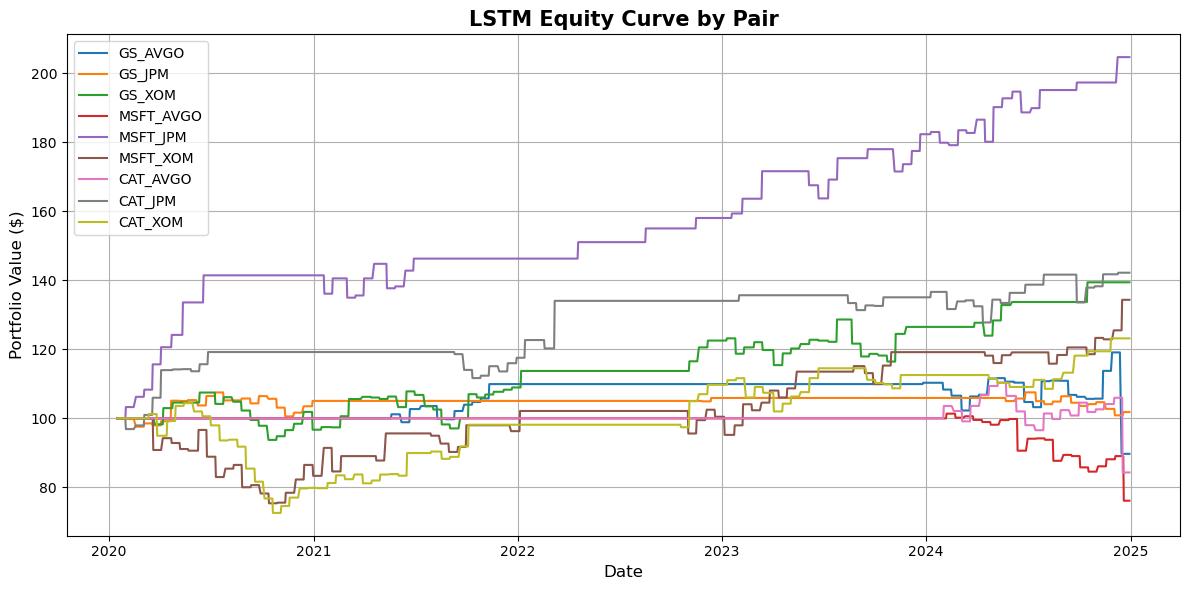


Final Portfolio Value: $1,095.94

Trade Summary:
  GS_AVGO: 33 trades | Total PnL: $-10.28 | Avg PnL: $-0.31
  GS_JPM: 38 trades | Total PnL: $1.82 | Avg PnL: $0.05
  GS_XOM: 68 trades | Total PnL: $39.45 | Avg PnL: $0.58
  MSFT_AVGO: 21 trades | Total PnL: $-23.88 | Avg PnL: $-1.14
  MSFT_JPM: 48 trades | Total PnL: $104.74 | Avg PnL: $2.18
  MSFT_XOM: 62 trades | Total PnL: $34.37 | Avg PnL: $0.55
  CAT_AVGO: 21 trades | Total PnL: $-15.68 | Avg PnL: $-0.75
  CAT_JPM: 43 trades | Total PnL: $42.23 | Avg PnL: $0.98
  CAT_XOM: 66 trades | Total PnL: $23.20 | Avg PnL: $0.35

Year-End Portfolio Values:
               GS_AVGO      GS_JPM      GS_XOM   MSFT_AVGO    MSFT_JPM  \
Date                                                                     
2020-12-31  100.000000  105.054362   96.714289  100.000000  141.466368   
2021-12-31  109.935056  105.054362  108.956436  100.000000  146.318490   
2022-12-31  109.935056  105.913621  122.557311  100.000000  158.094310   
2023-12-31  110.32097

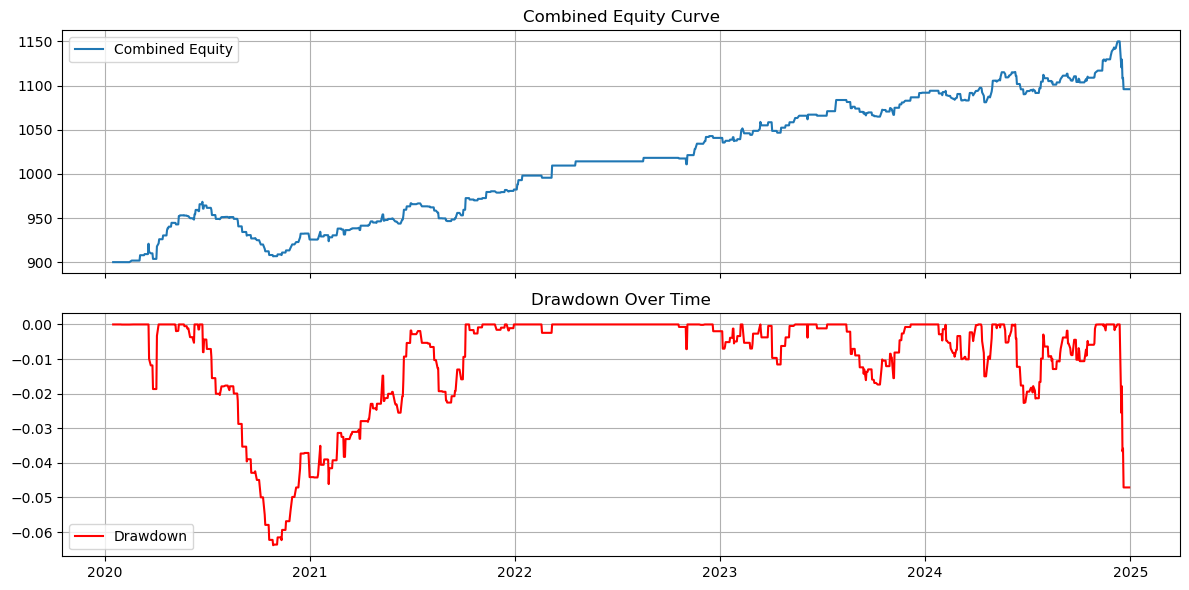

Pair: GS_AVGO
Date
2024-12-16    89.715352
2024-12-17    89.715352
2024-12-18    89.715352
2024-12-19    89.715352
2024-12-20    89.715352
2024-12-23    89.715352
2024-12-24    89.715352
2024-12-26    89.715352
2024-12-27    89.715352
2024-12-30    89.715352
Name: GS_AVGO, dtype: float64
----------------------------------------
Pair: GS_JPM
Date
2024-12-16    100.871481
2024-12-17    100.871481
2024-12-18    100.871481
2024-12-19    101.816811
2024-12-20    101.816811
2024-12-23    101.816811
2024-12-24    101.816811
2024-12-26    101.816811
2024-12-27    101.816811
2024-12-30    101.816811
Name: GS_JPM, dtype: float64
----------------------------------------
Pair: GS_XOM
Date
2024-12-16    139.446796
2024-12-17    139.446796
2024-12-18    139.446796
2024-12-19    139.446796
2024-12-20    139.446796
2024-12-23    139.446796
2024-12-24    139.446796
2024-12-26    139.446796
2024-12-27    139.446796
2024-12-30    139.446796
Name: GS_XOM, dtype: float64
-----------------------------------

In [20]:
run_simulation(results, X_test_dict, testing_data)